In [1]:
# IMPORT ALL YOUR LIBRARIES
# SUGGESTED LIBRARIES
!pip install accelerate
!pip install transformers
import accelerate
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import TensorDataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

In [2]:
!mkdir /content/data

In [92]:
result_df = pd.read_csv("/content/maindatamain.csv")
# result_df = result_df.drop('article_id','' axis=1)
result_df = result_df.sample(frac=1).reset_index(drop=True)

# Assuming 'df' is your DataFrame
result_df['Antagonist'] = result_df['label'].apply(lambda x: 1 if x == 'Antagonist' else 0)
result_df['Protagonist'] = result_df['label'].apply(lambda x: 1 if x == 'Protagonist' else 0)
result_df['Innocent'] = result_df['label'].apply(lambda x: 1 if x == 'Innocent' else 0)

result_df

mentioned_entity        label fine_grained_role1  \
0                              Russia  Protagonist           Virtuous   
1                   Professor Harries   Antagonist              Bigot   
2                                Kyiv     Innocent             Victim   
3                            Russians   Antagonist         Instigator   
4     Coalition Provisional Authority   Antagonist            Corrupt   
...                               ...          ...                ...   
1698                           Moscow   Antagonist  Foreign Adversary   
1699                          Ukraine  Protagonist           Underdog   
1700                   United Nations   Antagonist             Tyrant   
1701                   Vladimir Putin   Antagonist             Tyrant   
1702                          Ukraine     Innocent             Victim   

                                               sentence  Antagonist  \
0     West contributed to the coup in Ukraine, the s...           0   
1     Harries’s Claim That Climate Change Will Make ...           1   
2     Here are five sentences, each 1000 characters ...           0   
3     While some Russians may oppose Putin, the over...           1   
4     The Coalition Provisional Authority's disastro...           1   
...                                                 ...         ...   
1698  Moscow, in its blatant disregard for Moldovan ...           1   
1699  As a determined underdog competing against glo...           0   
1700                                                 .$           1   
1701  Vladimir Putin, the ruthless tyrant, initiated...           1   
1702  The resilient spirit of Ukraine, a nation stri...           0   

      Protagonist  Innocent  
0               1         0  
1               0         0  
2               0         1  
3               0         0  
4               0         0  
...           ...       ...  
1698            0         0  
1699            1         0  
1700            0         0  
1701            0         0  
1702            0         1  

[1703 rows x 7 columns]

In [94]:
label_df = result_df[['sentence','Protagonist','Antagonist','Innocent']]
label_df

sentence  Protagonist  \
0     West contributed to the coup in Ukraine, the s...            1   
1     Harries’s Claim That Climate Change Will Make ...            0   
2     Here are five sentences, each 1000 characters ...            0   
3     While some Russians may oppose Putin, the over...            0   
4     The Coalition Provisional Authority's disastro...            0   
...                                                 ...          ...   
1698  Moscow, in its blatant disregard for Moldovan ...            0   
1699  As a determined underdog competing against glo...            1   
1700                                                 .$            0   
1701  Vladimir Putin, the ruthless tyrant, initiated...            0   
1702  The resilient spirit of Ukraine, a nation stri...            0   

      Antagonist  Innocent  
0              0         0  
1              1         0  
2              0         1  
3              1         0  
4              1         0  
...          ...       ...  
1698           1         0  
1699           0         0  
1700           1         0  
1701           1         0  
1702           0         1  

[1703 rows x 4 columns]

In [97]:
train_df = label_df[:1200]
validation_df = label_df[1200:1600]
test_df = label_df[1600:]
train_labels_df = label_df[:1200]
validation_labels_df = label_df[1200:1600]
test_labels_df = label_df[1600:]


In [98]:
train_sentences = train_df['sentence'].values.tolist()
train_labels = train_labels_df.iloc[:, 1:].values
train_labels = train_labels.astype(np.float32)

validation_sentences = validation_df['sentence'].values.tolist()
validation_labels = validation_labels_df.iloc[:, 1:].values
validation_labels = validation_labels.astype(np.float32)

In [99]:
# from transformers import AutoTokenizer

# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3, problem_type="multi_label_classification")
# model

from transformers import AutoTokenizer, RobertaForSequenceClassification

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=3, problem_type="multi_label_classification")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



## [20 Points] Task 04 -  Training Loop


In this task, you are required to implement the training loop for fine tuning your model. You are also required to plot on the same graph: Loss vs Epochs & Accuracy vs Epochs

In [100]:
class ArgDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [101]:
test_labels_df

sentence  Protagonist  \
1600  for its battle against Russia is nearing a pea...            1   
1601  ties because of resistance.\n\nThe official sa...            0   
1602                                                 .$            0   
1603  Israel's decision to postpone Zelensky's visit...            0   
1604  ignia sewn on their uniforms,” Igor Kimakovsky...            0   
...                                                 ...          ...   
1698  Moscow, in its blatant disregard for Moldovan ...            0   
1699  As a determined underdog competing against glo...            1   
1700                                                 .$            0   
1701  Vladimir Putin, the ruthless tyrant, initiated...            0   
1702  The resilient spirit of Ukraine, a nation stri...            0   

      Antagonist  Innocent  
1600           0         0  
1601           1         0  
1602           1         0  
1603           0         1  
1604           1         0  
...          ...       ...  
1698           1         0  
1699           0         0  
1700           1         0  
1701           1         0  
1702           0         1  

[103 rows x 4 columns]

In [102]:
train_encodings = tokenizer(train_sentences, padding = True, truncation = True, max_length = 512)
train_dataset = ArgDataset(train_encodings, train_labels)

validation_encodings = tokenizer(validation_sentences, padding = True, truncation = True, max_length = 512)
validation_dataset = ArgDataset(validation_encodings, validation_labels)

In [103]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=".",
    eval_strategy="epoch",
    logging_dir="./logs",
    save_strategy="epoch",
    num_train_epochs = 15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    learning_rate = 8e-6,
    logging_steps=50,
    metric_for_best_model="f1"
)

# training_args = TrainingArguments(
#     output_dir=".",
#     evaluation_strategy="epoch",
#     logging_dir="./logs",
#     save_strategy="epoch",
#     num_train_epochs = 8,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     load_best_model_at_end=True,
#     weight_decay=0.01,
#     learning_rate = 8e-6,
#     warmup_steps = 30,
#     logging_steps= 100,
#     metric_for_best_model="f1"
# )

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

label_names = train_labels_df.columns[1:].tolist()

def compute_metrics(pred):
    labels = pred.label_ids
    # print(pred.predictions)
    preds = (pred.predictions[0] > 0.5).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    # Generate classification report
    # report = classification_report(labels, preds, target_names=label_names, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        # 'classification_report': report
    }

    # 52f62ca836aef0d505d954cd55a283290f9cc2c5

In [105]:
import torch
from torch import nn
from transformers import Trainer

# Define the Contrastive Loss function
contrastive_loss_fn = nn.CosineEmbeddingLoss(margin=0.5)

# Function to create positive and negative pairs based on fine-grained roles
def create_pairs(embeddings, labels):
    positive_pairs = []
    negative_pairs = []

    # Ensure labels are single scalar values for comparison
    labels = labels.cpu().numpy()  # Convert to numpy for easier indexing and comparison
    # print(labels)

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            # Compare scalar values for each label to determine positive/negative pairs
            p = np.array(labels[i])
            q = np.array(labels[j])
            are_equal = np.allclose(p, q)
            if are_equal:  # Positive pair
                positive_pairs.append((embeddings[i], embeddings[j]))
            else:  # Negative pair
                negative_pairs.append((embeddings[i], embeddings[j]))

    return positive_pairs, negative_pairs


class ContrastiveTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Classification loss
        labels = inputs.get("labels")
        outputs = model(**inputs, output_hidden_states=True)
        classification_loss = outputs.loss

        # Obtain embeddings from the last hidden state
        embeddings = outputs.hidden_states[-1][:, 0, :]
        positive_pairs, negative_pairs = create_pairs(embeddings, labels)

        contrastive_loss = 0

        # Calculate contrastive loss for positive pairs
        if positive_pairs:
            pos_emb1 = torch.stack([p[0] for p in positive_pairs])
            pos_emb2 = torch.stack([p[1] for p in positive_pairs])
            contrastive_loss += contrastive_loss_fn(pos_emb1, pos_emb2, torch.ones(pos_emb1.size(0)).to(pos_emb1.device))

        # Calculate contrastive loss for negative pairs
        if negative_pairs:
            neg_emb1 = torch.stack([n[0] for n in negative_pairs])
            neg_emb2 = torch.stack([n[1] for n in negative_pairs])
            contrastive_loss += contrastive_loss_fn(neg_emb1, neg_emb2, -torch.ones(neg_emb1.size(0)).to(neg_emb1.device))

        # Combine classification and contrastive loss
        total_loss = classification_loss + 0.08 * contrastive_loss  # Adjust weight as needed

        return (total_loss, outputs) if return_outputs else total_loss


In [106]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=validation_dataset,
#     compute_metrics=compute_metrics,
# )

# trainer.train()

trainer = ContrastiveTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


TrainOutput(global_step=1125, training_loss=0.1488892116546631, metrics={'train_runtime': 1363.4462, 'train_samples_per_second': 13.202, 'train_steps_per_second': 0.825, 'total_flos': 2987776192716000.0, 'train_loss': 0.1488892116546631, 'epoch': 15.0})

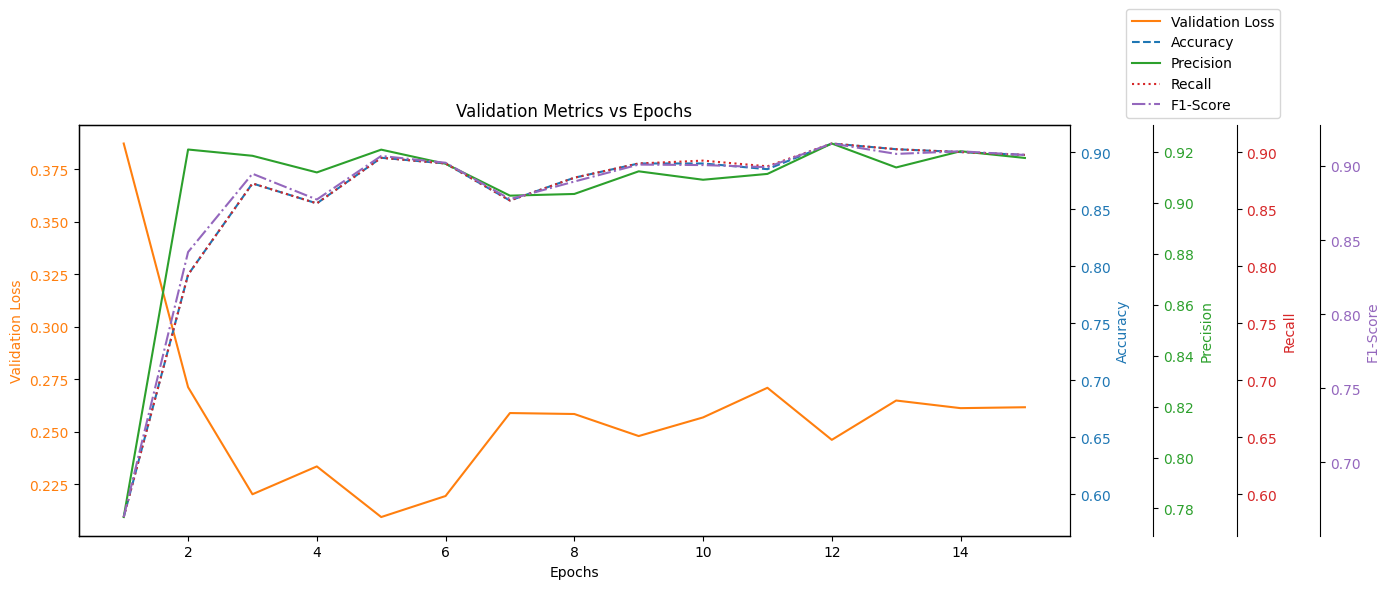

In [107]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer
log_history = trainer.state.log_history

# Initialize lists for storing values
losses = []
accuracies = []
precisions = []
f1_scores = []
recalls = []

# Parse through the log history and extract values
for entry in log_history:
    if 'eval_loss' in entry and 'eval_accuracy' in entry and 'eval_precision' in entry and 'eval_recall' in entry and 'eval_f1' in entry:
        losses.append(entry['eval_loss'])
        accuracies.append(entry['eval_accuracy'])
        precisions.append(entry['eval_precision'])
        f1_scores.append(entry['eval_f1'])
        recalls.append(entry['eval_recall'])

# Define epochs (adjust based on your actual epoch range)
epochs = list(range(1, len(losses) + 1))

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the first metric (loss) on the primary y-axis
ax1.plot(epochs, losses, color='tab:orange', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, accuracies, color='tab:blue', linestyle='--', label='Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Create a tertiary y-axis for Precision
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(epochs, precisions, color='tab:green', linestyle='-', label='Precision')
ax3.set_ylabel('Precision', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Create a fourth y-axis for Recall
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth y-axis
ax4.plot(epochs, recalls, color='tab:red', linestyle=':', label='Recall')
ax4.set_ylabel('Recall', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

# Create a fifth y-axis for F1-score
ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 180))  # Offset the fifth y-axis
ax5.plot(epochs, f1_scores, color='tab:purple', linestyle='-.', label='F1-Score')
ax5.set_ylabel('F1-Score', color='tab:purple')
ax5.tick_params(axis='y', labelcolor='tab:purple')

# Add legends for each line
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines5, labels5 = ax5.get_legend_handles_labels()

ax2.legend(lines1 + lines2 + lines3 + lines4 + lines5,
           labels1 + labels2 + labels3 + labels4 + labels5,
           loc='lower left', bbox_to_anchor=(1.05, 1))

# Title and grid
plt.title('Validation Metrics vs Epochs')
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


In [108]:
model.save_pretrained("/content/")
model = BertForSequenceClassification.from_pretrained("/content/")

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/ and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.inte

In [114]:
# test_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))
test_labels_df

Index                                           sentence  Protagonist  \
1600      1  for its battle against Russia is nearing a pea...            1   
1601      2  ties because of resistance.\n\nThe official sa...            0   
1602      3                                                 .$            0   
1603      4  Israel's decision to postpone Zelensky's visit...            0   
1604      5  ignia sewn on their uniforms,” Igor Kimakovsky...            0   
...     ...                                                ...          ...   
1698     99  Moscow, in its blatant disregard for Moldovan ...            0   
1699    100  As a determined underdog competing against glo...            1   
1700    101                                                 .$            0   
1701    102  Vladimir Putin, the ruthless tyrant, initiated...            0   
1702    103  The resilient spirit of Ukraine, a nation stri...            0   

      Antagonist  Innocent  
1600           0         0  
1601           1         0  
1602           1         0  
1603           0         1  
1604           1         0  
...          ...       ...  
1698           1         0  
1699           0         0  
1700           1         0  
1701           1         0  
1702           0         1  

[103 rows x 5 columns]

In [113]:
# test_labels_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))
test_labels_df

Index                                           sentence  Protagonist  \
1600      1  for its battle against Russia is nearing a pea...            1   
1601      2  ties because of resistance.\n\nThe official sa...            0   
1602      3                                                 .$            0   
1603      4  Israel's decision to postpone Zelensky's visit...            0   
1604      5  ignia sewn on their uniforms,” Igor Kimakovsky...            0   
...     ...                                                ...          ...   
1698     99  Moscow, in its blatant disregard for Moldovan ...            0   
1699    100  As a determined underdog competing against glo...            1   
1700    101                                                 .$            0   
1701    102  Vladimir Putin, the ruthless tyrant, initiated...            0   
1702    103  The resilient spirit of Ukraine, a nation stri...            0   

      Antagonist  Innocent  
1600           0         0  
1601           1         0  
1602           1         0  
1603           0         1  
1604           1         0  
...          ...       ...  
1698           1         0  
1699           0         0  
1700           1         0  
1701           1         0  
1702           0         1  

[103 rows x 5 columns]

In [115]:
# predictions = []
# threshold = 0.5

# for idx, row in test_df.iterrows():
#     arg_id = row['Index']
#     text = row['Prompt']
#     encoding = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
#     with torch.no_grad():
#         outputs = model(**encoding)

#     sigmoid = torch.nn.Sigmoid()
#     predictions_tensor = sigmoid(outputs.logits)

#     predicted_labels = []
#     for prob in predictions_tensor.flatten():
#         if prob >= threshold:
#           label = 1
#         else:
#           label =  0
#         predicted_labels.append(label)

#     predictions.append([arg_id] + predicted_labels)

# data = {'Index': [entry[0] for entry in predictions]}

# for i, label in enumerate(test_labels_df.columns[2:]):
#     data[label] = [entry[i+1] for entry in predictions]
# predictions_df = pd.DataFrame(data)


# # output_path = "/content/output/my_model_predictions.tsv"
# # predictions_df.to_csv(output_path, sep='\t', index=False)


In [146]:
predictions = []
threshold = 0.51

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check for GPU or use CPU
model.to(device)  # Move model to device

for idx, row in test_df.iterrows():
    arg_id = row['Index']
    text = row['sentence']

    # Tokenize and move inputs to the same device
    encoding = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    encoding = {key: value.to(device) for key, value in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)

    sigmoid = torch.nn.Sigmoid()
    predictions_tensor = sigmoid(outputs.logits)  # Apply sigmoid for probabilities

    # Convert predictions to binary labels based on threshold
    predicted_labels = (predictions_tensor >= threshold).int().squeeze().tolist()  # Use tensor comparison

    predictions.append([arg_id] + predicted_labels)

# Prepare final DataFrame
data = {'Index': [entry[0] for entry in predictions]}

for i, label in enumerate(test_labels_df.columns[2:]):
    data[label] = [entry[i + 1] for entry in predictions]

predictions_df = pd.DataFrame(data)

# Uncomment to save the predictions to a file
# output_path = "/content/output/my_model_predictions.tsv"
# predictions_df.to_csv(output_path, sep='\t', index=False)


In [147]:
predictions_df

Index  Protagonist  Antagonist  Innocent
0        1            0           1         0
1        2            0           1         0
2        3            0           0         0
3        4            0           1         0
4        5            0           1         0
..     ...          ...         ...       ...
98      99            0           1         0
99     100            0           1         0
100    101            0           0         0
101    102            0           1         0
102    103            0           1         0

[103 rows x 4 columns]

In [148]:
true_pred = test_labels_df[['Index','Protagonist','Antagonist','Innocent']]
true_pred

Index  Protagonist  Antagonist  Innocent
1600      1            1           0         0
1601      2            0           1         0
1602      3            0           1         0
1603      4            0           0         1
1604      5            0           1         0
...     ...          ...         ...       ...
1698     99            0           1         0
1699    100            1           0         0
1700    101            0           1         0
1701    102            0           1         0
1702    103            0           0         1

[103 rows x 4 columns]

In [149]:
true_labels = true_pred[['Protagonist', 'Antagonist', 'Innocent']]
pred_labels = predictions_df[['Protagonist', 'Antagonist', 'Innocent']]

f1_average = f1_score(true_labels, pred_labels, average='macro')
print(f"Average F1 Score: {f1_average}")

Average F1 Score: 0.22374429223744294


In [150]:

from sklearn.metrics import accuracy_score

true_labels = true_pred[['Protagonist', 'Antagonist', 'Innocent']]
pred_labels = predictions_df[['Protagonist', 'Antagonist', 'Innocent']]

exact_match_count = 0
total_count = len(true_labels)

for i in range(total_count):
  if true_labels.iloc[i].equals(pred_labels.iloc[i]):
    exact_match_count += 1

exact_match_ratio = exact_match_count / total_count

print(f"Exact Match Ratio: {exact_match_ratio}")

Exact Match Ratio: 0.47572815533980584
